In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


In [2]:
!pip install pandas

In [3]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


In [4]:
!pip install gensim

# Create embedding matrix
We'll use the word2vec module from gensim to create an embedding matrix that can be used by tensorflow

In [5]:
# Import the libraries
import pandas as pd
import numpy as np
from numpy import savez_compressed
import ast
from tensorflow.keras.preprocessing.text import Tokenizer
import datetime
from gensim.models.word2vec import FAST_VERSION
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt

### Load in the data

In [6]:
# Load in the data
data_list = [a, b, c, d, e, f, g, h, i ,f] = [None, None, None, None, None, None, None, None, None, None]
data_location = '../Datasets/AmazonCat-13K/processed/' 
for i in range(len(data_list)):
    data_list[i] = pd.read_csv(data_location + f'first_pass_no{i + 1}.csv', encoding='latin1')
    
# Concatenate all the data and reset the index
data = pd.concat(data_list, sort=False)
data = data.reset_index()

# Delete unused var (to save memory)
del data_list

In [7]:
# Convert the labels from string to array (return unique values only)
data['labels'] = data['labels'].apply(lambda labels: list(set(ast.literal_eval(labels))))

In [8]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [9]:
# Create function to join title and description
def join_title_and_description(row):
    return f'{row["title"]} {row["description"]}'

In [10]:
# Create a new column that combines the title and description
data['title_and_description'] = data.apply(lambda row: join_title_and_description(row), axis=1)

In [11]:
# Drop title and description columns (to save memory)
data = data.drop(labels=['title', 'description'], axis=1)

In [12]:
# Have a look at the shape
data.shape

(1494407, 4)

In [13]:
# Have a look at the first 3 rows
data.head(n=3)

,index,item_id,labels,title_and_description
0,0,ID:B0027DQHA0,"[TV, Music, Classical, Movies & TV]",Sao Paulo Samba (2008) Conducted by John Nesch...
1,1,ID:0756400120,"[Literature & Fiction, United States, Books, S...",Past Imperfect (Daw Book Collectors) This fast...
2,2,ID:B00024YAOQ,"[Business Life, Motivation & Self-Improvement,...",Winning Every Time: How to Use the Skills of a...


### Tokenize the data

In [14]:
# Convert from df to list so it can be processed
text = data['title_and_description'].tolist()

In [15]:
# Tokenize the data
VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text)

In [16]:
# Create a squence from the tokens
sequences = tokenizer.texts_to_sequences(text)

In [17]:
# Delete unused var (to save memory)
del text

In [18]:
# Have a look at the first sequence
print(sequences[0])

[29260, 21551, 12365, 3328, 4450, 19, 237, 211, 1219, 1, 2781, 7, 2982, 19, 55, 28920, 6087, 3, 1991, 100, 123, 181, 1, 2781, 264, 301, 5176, 1, 3727, 9, 16, 13217, 1255, 3, 6394, 2, 1991, 100, 1500, 131, 499]


In [19]:
# Convert sequence of integers to sequence of tokens so they can be processed by Word2Vec
stringified_sequences = []
# for sequence in padded_sequences:
for sequence in sequences:
    stringified_sequence = [str(index) for index in sequence]
    stringified_sequences.append(stringified_sequence)
    del stringified_sequence # to save memory??

In [20]:
# Have a look at the first sequence of tokens
print(stringified_sequences[0])

['29260', '21551', '12365', '3328', '4450', '19', '237', '211', '1219', '1', '2781', '7', '2982', '19', '55', '28920', '6087', '3', '1991', '100', '123', '181', '1', '2781', '264', '301', '5176', '1', '3727', '9', '16', '13217', '1255', '3', '6394', '2', '1991', '100', '1500', '131', '499']


### Create the word2vec word vectors
In his original CNN-Kim paper, the author used a pre-trained word2vec embedding developed by Google. They provided the link but it's broken. So, we'll create our own word2vec embeddings for now.

In [21]:
# Check gensim version used
FAST_VERSION

1

In [22]:
# Create loss store
loss_store = []

In [23]:
# Create callback function
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.previous_cumulative_loss = 0
        self.start_time = 0
    
    def on_epoch_begin(self, model):
        self.start_time = datetime.datetime.now()

    def on_epoch_end(self, model):
        cumulative_loss = model.get_latest_training_loss()
        loss_now = cumulative_loss - self.previous_cumulative_loss
        loss_store.append(loss_now)
        self.previous_cumulative_loss = cumulative_loss
        
        end_time = datetime.datetime.now()
        time_taken_seconds = (end_time - self.start_time).total_seconds()
        minutes = int(time_taken_seconds // 60)
        if minutes < 10:
            minutes = '0' + str(minutes)
        seconds = round(time_taken_seconds % 60)
        if seconds < 10:
            seconds = '0' + str(seconds)
        
        print(f'{self.epoch} ----- {loss_now} ----- {minutes}:{seconds}')
        self.epoch += 1

In [24]:
# Train the word2vec word vectors (150 dimensions)
EMBEDDING_DIMENSION = 150
print(f'Epoch ----- Loss ----- Time')
word_vectors = Word2Vec(sentences = stringified_sequences,
                        sg = 0, # 0 for continuous bag of words model, 1 for skip-gram model
                        size = EMBEDDING_DIMENSION, # Dimensionality of the word vectors
                        window = 5, # Maximum distance between the current and predicted word within a sentence
                        workers = 12, # Use these many worker threads to train the model 
                        compute_loss=True, 
                        callbacks=[callback()],
                        iter = 20) # Run this many time through the dataset

Epoch ----- Loss ----- Time
1 ----- 29372442.0 ----- 02:33
2 ----- 18459182.0 ----- 02:33
3 ----- 17172192.0 ----- 02:32
4 ----- 5853488.0 ----- 02:32
5 ----- 4276736.0 ----- 02:32
6 ----- 4251704.0 ----- 02:32
7 ----- 4190864.0 ----- 02:31
8 ----- 4148288.0 ----- 02:32
9 ----- 4064368.0 ----- 02:32
10 ----- 3961800.0 ----- 02:32
11 ----- 3845496.0 ----- 02:31
12 ----- 3716160.0 ----- 02:32
13 ----- 3568448.0 ----- 02:32
14 ----- 3400792.0 ----- 02:32
15 ----- 3204800.0 ----- 02:33
16 ----- 3029624.0 ----- 02:32
17 ----- 2759608.0 ----- 02:32
18 ----- 2476488.0 ----- 02:32
19 ----- 2161080.0 ----- 02:32
20 ----- 1829992.0 ----- 02:33


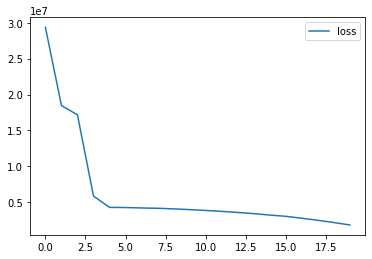

In [25]:
# Plot the loss at each itteration
plt.plot(loss_store, label='loss');
plt.legend();

In [26]:
# Check the number of tokens that have been trained for
len(word_vectors.wv.vocab.keys())

199999

In [27]:
# Check the dimensions of each token
word_vectors.wv.vector_size

150

In [28]:
# Delete unused var (to save memory)
del stringified_sequences

### Convert the word2vec mapping to an embedding matrix
An embedding matrix is the structure that TensorFlow will accept

In [29]:
# Create empty embedding matrix
weight_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIMENSION))

# Fill the matrix with word vectors
for i in range(VOCAB_SIZE - 1):
    weight_matrix[i + 1] = word_vectors.wv[str(i + 1)]

In [30]:
# Check the embedding matrix shape
weight_matrix.shape

(200000, 150)

In [31]:
# Save the embedding matrix to use for later
save_path = '../Datasets/AmazonCat-13K/processed/'
savez_compressed(save_path + 'embedding_matrix.npz', weight_matrix)
# np.savetxt(save_path + 'embedding_matrix.csv', weight_matrix, delimiter=',')

In [32]:
# Delete unused var (to save memory)
del weight_matrix

### Save a new dataset with the tokenized title and description

In [33]:
# Create empty dataframe
tokenized_data = pd.DataFrame(columns = ['item_id', 'tokenized_title_and_description', 'labels'])

In [34]:
# Add the data
tokenized_data['item_id'] = data['item_id'].copy()
tokenized_data['tokenized_title_and_description'] = sequences # This is the integer version
tokenized_data['labels'] = data['labels'].copy()

In [35]:
# Check the shape of the dataframe
tokenized_data.shape

(1494407, 3)

In [36]:
# Have a look at the first 3 rows
tokenized_data.head(n=3)

,item_id,tokenized_title_and_description,labels
0,ID:B0027DQHA0,"[29260, 21551, 12365, 3328, 4450, 19, 237, 211...","[TV, Music, Classical, Movies & TV]"
1,ID:0756400120,"[381, 15160, 38609, 41, 5949, 10, 477, 1179, 3...","[Literature & Fiction, United States, Books, S..."
2,ID:B00024YAOQ,"[646, 150, 56, 73, 5, 99, 1, 883, 3, 4, 3470, ...","[Business Life, Motivation & Self-Improvement,..."


In [37]:
# Create column of token counts
tokenized_data['token_count'] = tokenized_data['tokenized_title_and_description'].apply(lambda tokens: len(tokens))

In [38]:
# Check for rows with missing values
len(tokenized_data[tokenized_data['token_count'] == 0])

43

In [39]:
# Remove rows with missing values
tokenized_data = tokenized_data[tokenized_data.token_count != 0]

In [40]:
# Remove column of token counts
tokenized_data = tokenized_data.drop('token_count', axis = 1)

In [41]:
# Check the shape of the dataframe
tokenized_data.shape

(1494364, 3)

In [42]:
# Reset the index
tokenized_data = tokenized_data.reset_index(drop=True)

In [43]:
# Have a look at the first 3 rows
tokenized_data.head(n=3)

,item_id,tokenized_title_and_description,labels
0,ID:B0027DQHA0,"[29260, 21551, 12365, 3328, 4450, 19, 237, 211...","[TV, Music, Classical, Movies & TV]"
1,ID:0756400120,"[381, 15160, 38609, 41, 5949, 10, 477, 1179, 3...","[Literature & Fiction, United States, Books, S..."
2,ID:B00024YAOQ,"[646, 150, 56, 73, 5, 99, 1, 883, 3, 4, 3470, ...","[Business Life, Motivation & Self-Improvement,..."


In [44]:
# Create save_as_csv function
def save_as_csv(df, path):
    df.to_csv(path, 
              header=True, 
              index=None, 
              encoding='latin1')

In [45]:
# Save as csv (broken up into 5 files)
num_files = 10
size = tokenized_data.shape[0] // num_files
for file_num in range(num_files):
    if file_num == 0:
        save_as_csv(tokenized_data[:size], save_path + f'tokenized_no{file_num + 1}.csv')
    elif file_num == (num_files - 1):
        save_as_csv(tokenized_data[size * file_num:], save_path + f'tokenized_no{file_num + 1}.csv')
    else:
        save_as_csv(tokenized_data[size * file_num: size * (file_num + 1)], save_path + f'tokenized_no{file_num + 1}.csv')